Here we will look at some aggregations over specific start and stop locations. Going from point A to point B is a 'trip'.

Grouping statistics by trip cancut the data size by a large amount, as the number of trips:
${n \choose 2}^2 $ (choosing pickups and dropoffs). 

In [177]:
from feature_utils import load_hdf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

import xgboost as xgb

from joblib import dump, load
from sklearn.linear_model import LinearRegression

#taxi_linmod = load('taxi_lin_model.joblib')
taxi_treemod = xgb.Booster()
taxi_treemod.load_model("taxi_xgb_full")

#tnp_linmod = load('tnp_lin_model.joblib')
tnp_treemod = xgb.Booster()
tnp_treemod.load_model("tnp_xgb_full")


data = {"path":"data/","taxi":"taxi_test.h5", "rideshare":"tnp_test.h5" }

In [36]:
X = load_hdf(data["path"]+data["rideshare"],100)
y = X["Final_Fare"]
X.drop(["Final_Fare"], axis = 1, inplace = True)
dtest = xgb.DMatrix(X.values)

model_preds = tnp_treemod.predict(dtest)
model_preds.size

100

In [3]:
rideshare = load_hdf(data["path"]+data["rideshare"],100)
rideshare.head()

,Trip_Seconds,Trip_Miles,Pickup_Community_Area,Dropoff_Community_Area,Shared_Trip_Authorized,Pickup_Centroid_Latitude,Pickup_Centroid_Longitude,Dropoff_Centroid_Latitude,Dropoff_Centroid_Longitude,vel_mph,Final_Fare,l2_dist_km,x_dist_km,y_dist_km,bearing,bAirport,day_of_wk,hour
6283605,1913.0,6.7,77.0,22.0,False,41.985472,-87.653794,41.929330,-87.711974,12.608468,17.50,7.881464,4.808806,6.242793,-142.361378,False,5,0
10327851,1335.0,5.4,7.0,32.0,False,41.929078,-87.646293,41.880994,-87.632746,14.561798,15.00,5.462890,1.120689,5.346614,168.152913,False,1,8
581229,1560.0,5.3,6.0,28.0,False,41.934540,-87.643023,41.878667,-87.671654,12.230769,10.67,6.649193,2.368313,6.212725,-159.115063,False,6,14
10148217,590.0,5.9,44.0,68.0,False,41.740206,-87.615970,41.777196,-87.642498,36.000000,12.50,4.664751,2.201044,4.113162,-28.136520,False,1,22
1776825,1126.0,4.8,6.0,4.0,True,41.944227,-87.655998,41.975171,-87.687516,15.346359,5.00,4.316367,2.606686,3.440859,-37.129196,False,3,15


In [4]:
name_mapping = {'Pickup_Centroid_Latitude': 'latp',
                 'Dropoff_Centroid_Latitude': 'latd',
                 'Pickup_Centroid_Longitude': 'longp',
                 'Dropoff_Centroid_Longitude': 'longd'}
    
rideshare.rename(index=str, columns = name_mapping, inplace=True)
locs = list(name_mapping.values())

In [5]:
for coord in locs:
    print(rideshare[coord].nunique())

873
875
872
874


So there are about 900 unique lat/longs giving ~ 500k trip combinations.

In [6]:
# total distinct rides:
900**2/2

405000.0

#### Grouping by rides:

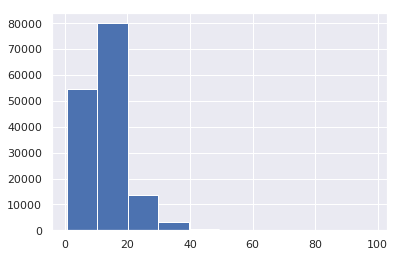

In [178]:
rideshare.groupby(["latp","longd"]).Final_Fare.mean().hist()

In [8]:
def find_boundary(df, padding = 0.001):
    topleft = (max(df.latp.max(),df.latd.max())+padding,min(df.longp.min(),df.longd.min())-padding)
    bottomright = (min(df.latp.min(),df.latd.min())-padding,max(df.longp.max(),df.longd.max())+padding)
    return topleft, bottomright

def coord_bins(df, n = 50):
    """Generate the grid from the lat and long."""
    # TODO: consider non-rectangular grid
    topleft, bottomright = find_boundary(df)
    lat_axis = np.linspace(bottomright[0],topleft[0],n)
    long_axis = np.linspace(topleft[1],bottomright[1],n)
    return lat_axis, long_axis

#def bin_densities(df, lat_axis,long_axis):
 #   df[(df.latp < lat_axis[0] & df.latp < lat_axis[1]]
    

def cut_along_lat_long(df, locs, n_bins = 100):
    labels = np.arange(n_bins-1)
    mapping = {loc:loc + "_b" for loc in locs}
    lat_axis, long_axis = coord_bins(df, n_bins)
    
    for lat in locs[0:2]:
        df[mapping[lat]] = pd.cut(df[lat], bins = lat_axis,labels = labels, retbins=False)

    for long in locs[2:]:
        df[mapping[long]] = pd.cut(df[long], bins = long_axis,labels = labels, retbins=False)
        
    df['path'] = list(zip(zip(df.latp_b,df.longp_b), zip(df.latd_b,df.longd_b)))
    

The way we have done this, there are a lot of 
trips with very few instances. Probably should use
some sort of adaptive grid. I think the simplest 

In [9]:
#lata, longa = coord_bins(rideshare, n = 10)
#rideshare.groupby('path').Trip_Seconds.count().hist(bins = 100, range = (0,100), log = True)

KeyError: 'path'

In [10]:
cut_along_lat_long(rideshare, locs, n_bins = 20)

In [11]:
# total unique trips with binning above
print(rideshare.groupby('path').Trip_Miles.count().count())

16589


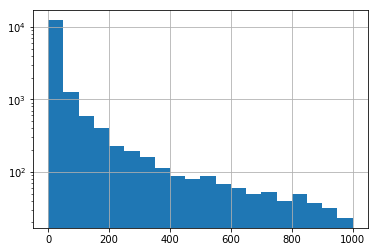

In [12]:
rideshare.groupby('path').Final_Fare.count().hist(bins = 20, range = (0,1000),log = True)

Prints the number of unique trips at this binsize
150k is about the max for the tnp_test data, we know the max possible based on the input data binning
s 400k. We need some balance of bin size between having enough data to show the user a histogram and accuracy.

issue: trip miles has somewhat significant deviation from each other even with fine binning... shared rides?

In [13]:
rideshare.groupby('path').Trip_Miles.count().count()

16589

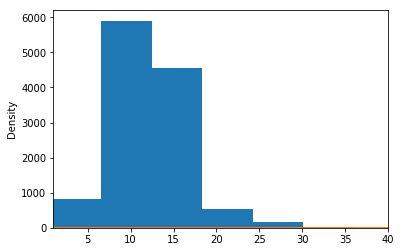

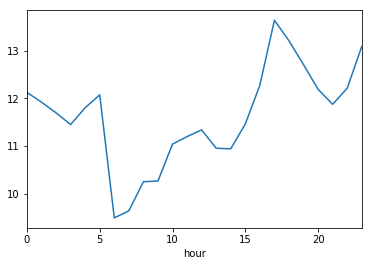

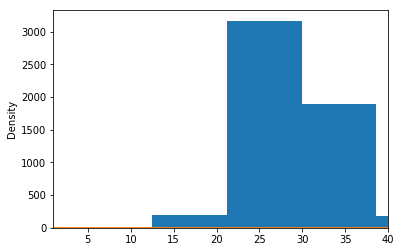

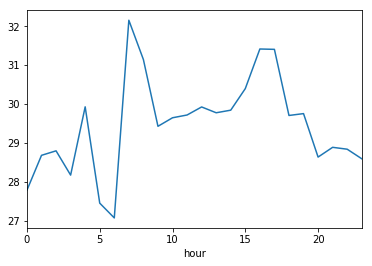

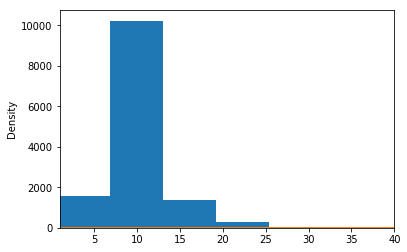

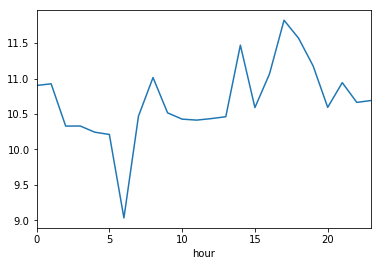

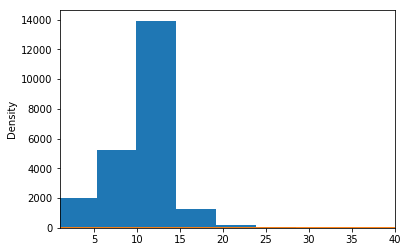

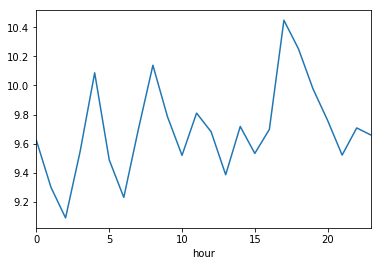

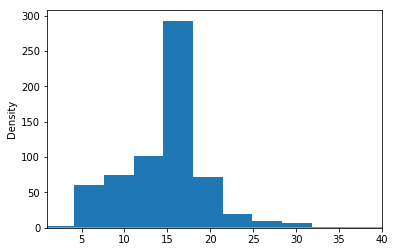

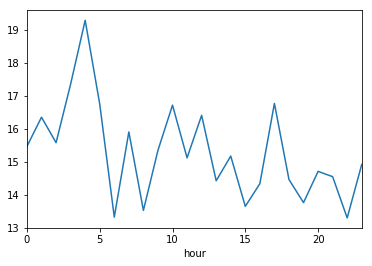

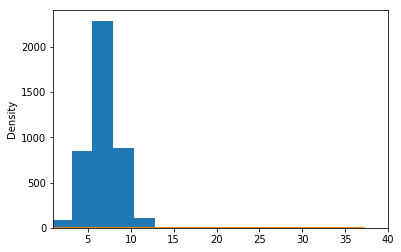

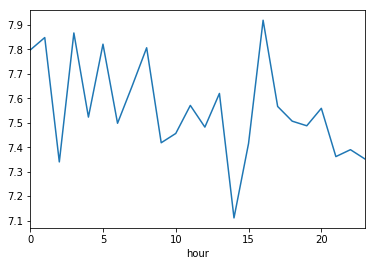

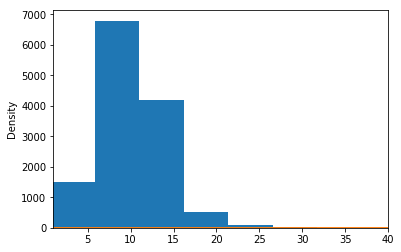

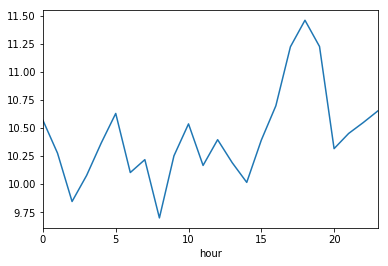

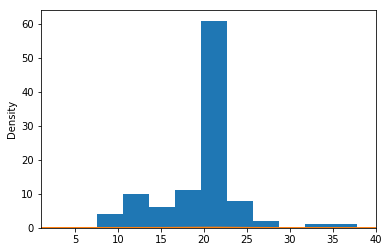

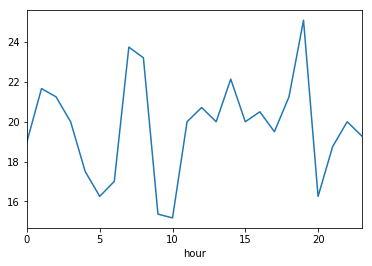

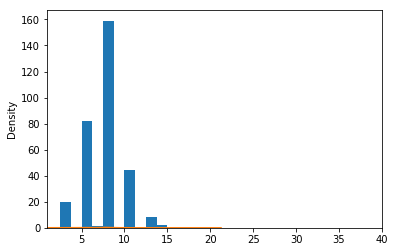

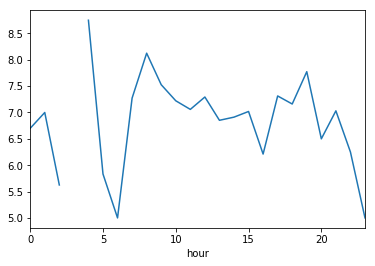

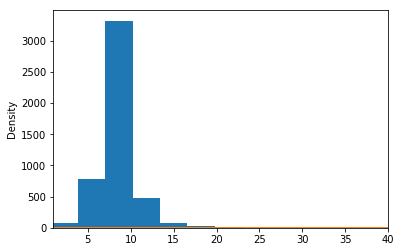

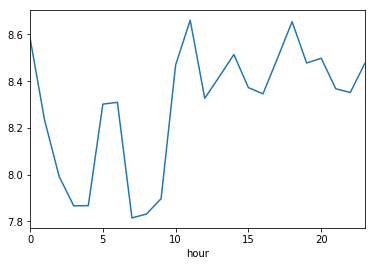

In [14]:
test_paths = rideshare.iloc[np.random.randint(0,len(rideshare.index),10)]['path'].values

for test_path in test_paths:
    rideshare[rideshare.path == test_path].Final_Fare.hist(bins = 10, density = True)
    ax = rideshare[rideshare.path == test_path].Final_Fare.plot.kde()
    ax.set_xlim([1,40])
    plt.show()
    plt.show()
    rideshare[rideshare.path == test_path].groupby("hour").Final_Fare.mean().plot()
    plt.show()
    

TODO: Create a function to plot the route on a map and show this histogram at the same time. Intermediate data product is a histogram for each of these routes.

In [15]:
from matplotlib import animation, rc

In [ ]:
test_path = test_paths[4]
axes = rideshare[rideshare.path == test_path].groupby("hour").Final_Fare.plot.kde()

In [ ]:
def get_plot_data(axes):
    xs = []
    ys = []
    for i,ax in enumerate(axes):
        ax.set_xlim([1,40])
        line = ax.lines[i]
        xs.append(line.get_xdata())
        ys.append(line.get_ydata())
    return xs, ys
    
    

In [ ]:
from matplotlib import animation, rc

rc('animation', html='html5')
# First set up the figure, the axis, and the plot element we want to animate
fig, ax = plt.subplots()

ax.set_xlim(( 0, 50))
ax.set_ylim((0, .25))

line, = ax.plot([], [], lw=2)

# initialization function: plot the background of each frame
def init():
    line.set_data([], [])
    return (line,)


# animation function. This is called sequentially
def animate(i):
    x = xs[i]
    y = ys[i]
    line.set_data(x, y)
    return (line,)

In [ ]:
# call the animator. blit=True means only re-draw the parts that 
# have changed.
xs, ys = get_plot_data(axes)

anim = animation.FuncAnimation(fig, animate, init_func=init,
                               frames=7, interval=100, blit=True)

In [ ]:
anim

In [ ]:
test_paths = rideshare.iloc[np.random.randint(0,len(rideshare.index),10)]['path'].values

In [ ]:
animation.writers?

In [ ]:
import xgboost as xgb

In [116]:
# get DF indices corresponding to path
indices =rideshare[rideshare["path"] == test_paths[0]].index.values.astype(int).tolist()

(array([ 18.,  52., 110., 123., 162., 145., 139., 115., 104.,  90.,  92.,
         97., 153., 254., 282., 200., 232., 203., 193., 226., 246., 295.,
        343., 460., 555., 625., 578., 507., 372., 377., 285., 305., 319.,
        310., 289., 273., 229., 236., 212., 192., 175., 148., 132., 136.,
        130., 147., 156., 140., 147., 114.,  86.,  50.,  61.,  54.,  48.,
         50.,  32.,  32.,  19.,  16.,  16.,  10.,   7.,  13.,  11.,   7.,
          5.,   6.,   2.,   2.,   5.,   8.,   0.,   2.,   2.,   1.,   4.,
          2.,   2.,   1.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          1.,   0.,   2.,   0.,   0.,   0.,   0.,   2.,   0.,   1.,   0.,
          1.]),
 array([ 5.0334177,  5.2722282,  5.5110393,  5.74985  ,  5.988661 ,
         6.2274714,  6.466282 ,  6.705093 ,  6.9439034,  7.182714 ,
         7.421525 ,  7.6603355,  7.8991466,  8.137957 ,  8.376768 ,
         8.615579 ,  8.854389 ,  9.0932   ,  9.33201  ,  9.570822 ,
         9.809632 , 10.048443 , 10.287253 , 10

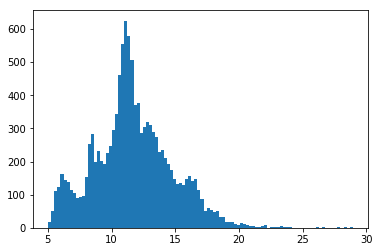

In [122]:
# get predictions for those indices fro the model
sample = X.loc[indices].values# .reshape(1,-1) for length 1 data
#print(sample.shape)
t = xgb.DMatrix(sample)
plt.hist(tnp_treemod.predict(t), bins = 100)

In [136]:
model_err = rideshare[rideshare.path == test_paths[0]].Final_Fare.values -tnp_treemod.predict(t)

In [145]:
np.std(model_err)  # so we're within a few bucks on those rides
# I think

2.8923862

We want a function that takes a single ride as input,
outputs the histogram and the prediction.

In [175]:
path_group = rideshare.groupby('path')

# let's just say a trip is a single row of the dataframe
def single_pt_estimate(trip):
    # Super crude way of formatting the data
    X = trip.drop("Final_Fare").values[:-5]
    print(trip.values.reshape(1,-1))
    t = xgb.DMatrix(X.reshape(1,-1))
    return tnp_treemod.predict(t)

#start, end are lat/long pairs
def ride_summary(df,trip):#start,end):
    #trip = find_bin(start,end)
    all_rides = df[df.path == trip.path]
    ax = all_rides.Final_Fare.plot.kde()
    # needs to be replaced with other data sources
    estimate = single_pt_estimate(trip)
    ax.axvline(estimate, color='k', linestyle='--')
    plt.show()
    
    

In [169]:
rideshare.iloc[1000].path

((11, 14), (12, 13))

[[1913.0 6.7 77.0 22.0 False 41.9854724225 -87.6537935286 41.9293297134
  -87.7119742544 12.608468 17.5 7.881463781510888 4.808806426368954
  6.242793238877335 -142.36137775414693 False 5 0 17 14 12 9
  ((17, 12), (14, 9))]]


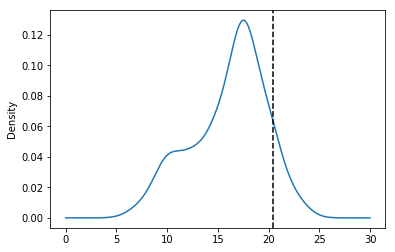

[[1335.0 5.4 7.0 32.0 False 41.9290776551 -87.64629347620001
  41.8809944707 -87.63274648870001 14.561798 15.0 5.462890171472705
  1.1206892678725475 5.3466137150835 168.15291330515913 False 1 8 14 11
  13 13 ((14, 13), (11, 13))]]


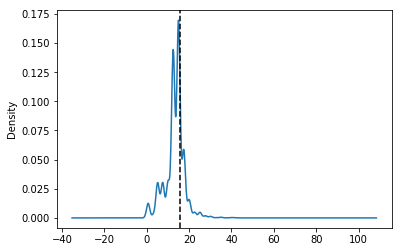

[[1560.0 5.3 6.0 28.0 False 41.9345397158 -87.6430228044 41.8786674201
  -87.6716536214 12.230769 10.67 6.649192690311749 2.368312642351284
  6.212724598224417 -159.11506318294676 False 6 14 14 11 13 11
  ((14, 13), (11, 11))]]


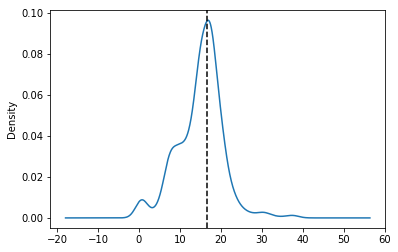

[[590.0 5.9 44.0 68.0 False 41.7402057565 -87.6159695226 41.7771962546
  -87.64249752709999 36.0 12.5 4.66475073433172 2.2010435945368383
  4.1131615332290234 -28.136520204176584 False 1 22 4 6 14 13
  ((4, 14), (6, 13))]]


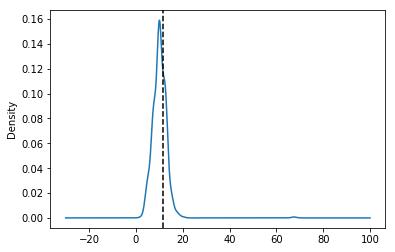

[[1126.0 4.8 6.0 4.0 True 41.9442266014 -87.6559981815 41.9751709433
  -87.6875155152 15.346359 5.0 4.316367009998724 2.606686422519119
  3.440858688361283 -37.12919616893148 False 3 15 15 16 12 11
  ((15, 12), (16, 11))]]


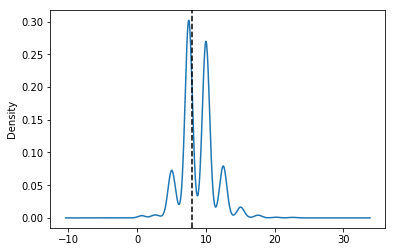

[[748.0 5.4 3.0 8.0 False 41.96581197 -87.6558787862 41.899602111
  -87.6333080367 25.989305 12.5 7.595271406474505 1.8661141902111735
  7.362210814871516 165.76205087753985 False 6 5 16 12 12 13
  ((16, 12), (12, 13))]]


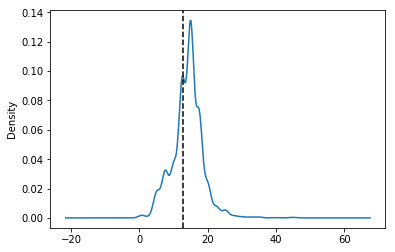

[[916.0 2.1 24.0 28.0 False 41.8996701799 -87.66983779819999
  41.885300022399996 -87.6428084655 8.253275 10.0 2.749331749031879
  2.2370614171623058 1.5978908663424016 125.52543214144136 False 0 7 12
  12 12 13 ((12, 12), (12, 13))]]


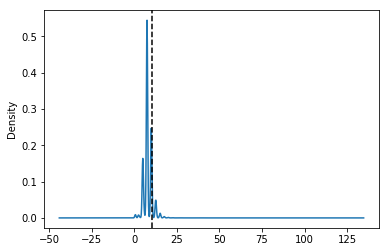

[[671.0 3.5 8.0 24.0 False 41.907491930300004 -87.6357600901
  41.9005603836 -87.6941973701 18.777943 10.0 4.897218689226795
  4.835922892947693 0.7707539156445146 -99.03569010818853 False 5 1 13 12
  13 10 ((13, 13), (12, 10))]]


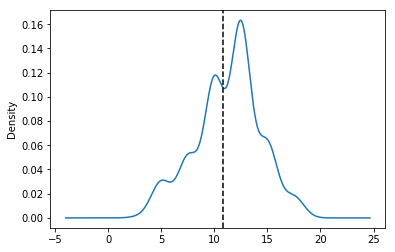

[[168.0 0.3 6.0 6.0 True 41.9426918444 -87.6517705068 41.946294535700005
  -87.65429808370001 6.4285717 5.0 0.45186485255076236
  0.20905191670736717 0.4006015607363181 -27.556070174250287 False 5 6 14
  15 12 12 ((14, 12), (15, 12))]]


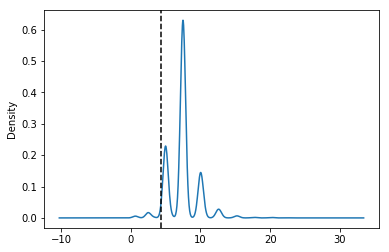

[[798.0 2.8 8.0 28.0 False 41.892507780900004 -87.6262149064
  41.8679024175 -87.6429586652 12.631578 10.0 3.0671222623256793
  1.3859394243972434 2.735995443328038 -153.12512016570096 False 2 15 12
  11 14 13 ((12, 14), (11, 13))]]


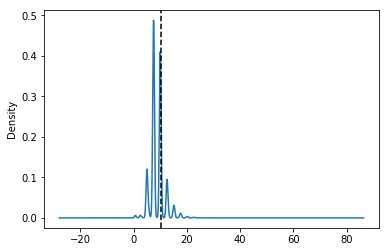

In [176]:
for i in range(10):
    ride_summary(rideshare,rideshare.iloc[i])

In [167]:
print(rideshare.iloc[0], X.iloc[0])

Trip_Seconds                             1913
Trip_Miles                                6.7
Pickup_Community_Area                      77
Dropoff_Community_Area                     22
Shared_Trip_Authorized                  False
latp                                  41.9855
longp                                -87.6538
latd                                  41.9293
longd                                 -87.712
vel_mph                               12.6085
Final_Fare                               17.5
l2_dist_km                            7.88146
x_dist_km                             4.80881
y_dist_km                             6.24279
bearing                              -142.361
bAirport                                False
day_of_wk                                   5
hour                                        0
latp_b                                     17
latd_b                                     14
longp_b                                    12
longd_b                           